In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from createData import createDataFrame


## Initialize Random Data Frame
# this data frame consists of data generated from a random "Quality" score between 0-1
# Intensity and Negative control concentration is generated from this quality score
toAnalyze = createDataFrame(1000002)

toAnalyze

,Trials,Quality,Negative_Control_Concentration,Intensity,Condition,Sample_ID
0,1.0,0.967695,3.86052,100.113,3,ND000001
1,2.0,0.985588,2.63787,105.112,3,ND000002
2,3.0,0.818611,14.6662,45.2552,1,ND000001
3,4.0,0.022704,53.3028,0.390184,1,ND000002
4,5.0,0.800394,14.2298,47.3924,3,ND000003
...,...,...,...,...,...,...
999997,999998.0,0.905111,1.8993,97.4122,3,ND333333
999998,999999.0,0.056571,45.0028,41.4726,2,ND333333
999999,1000000.0,0.104231,51.8043,25.5342,3,ND333334
1000000,1000001.0,0.252566,44.6267,27.4289,1,ND333334


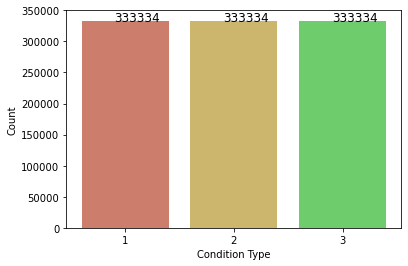

In [46]:
##Display counts of each condition type, describing the replicate setups

toAnalyze["Condition"].astype(str)
condition_types, condition_counts = np.unique(toAnalyze["Condition"], return_counts = True)
plt.bar(condition_types, condition_counts, color = ['#CC7D6C', '#CCB56C', '#6FCC6C'])
plt.xticks([1,2,3])
plt.text(0.9, condition_counts[0] + 10, condition_counts[0], fontsize = "large")
plt.text(1.9, condition_counts[1] + 10, condition_counts[1], fontsize = "large")
plt.text(2.9, condition_counts[2] + 10, condition_counts[2], fontsize = "large")
plt.xlabel("Condition Type")
plt.ylabel("Count")
plt.show()

In [47]:
##Initialize data for boxplots and barplot below

NTCboxData = []
IntboxData = []
negCount = []

for condition in [1,2,3]:
    NTCboxDatai = toAnalyze.loc[np.where(toAnalyze["Condition"] == condition), "Negative_Control_Concentration"]
    IntboxDatai = toAnalyze.loc[np.where(toAnalyze["Condition"] == condition), "Intensity"]
    negCounti = np.count_nonzero(toAnalyze.loc[np.where((toAnalyze["Condition"] == condition) &
                                                       (toAnalyze["Negative_Control_Concentration"] > 20)),"Negative_Control_Concentration"])
    
    NTCboxData.append(NTCboxDatai)
    IntboxData.append(IntboxDatai)
    negCount.append(negCounti)

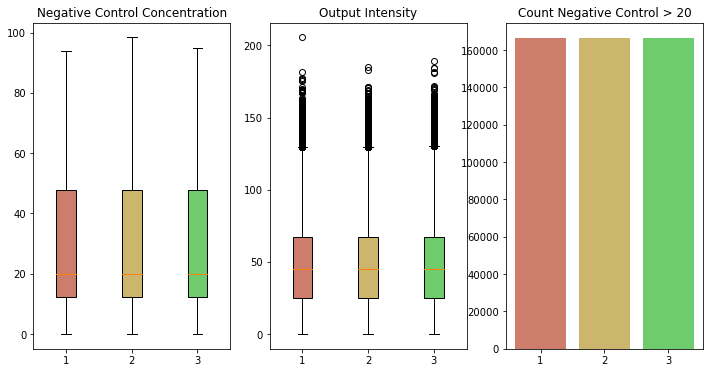

In [48]:
colors = ['#CC7D6C', '#CCB56C', '#6FCC6C']
fig, (ntc_ax, intensity_ax, countNTC_ax) = plt.subplots(1, 3, figsize = (12,6))

ntc_box = ntc_ax.boxplot(NTCboxData, patch_artist=True)
ntc_ax.set_title("Negative Control Concentration")

intBox = intensity_ax.boxplot(IntboxData, patch_artist=True)
intensity_ax.set_title("Output Intensity")

ntcCount = countNTC_ax.bar([1,2,3], negCount, color = ['#CC7D6C', '#CCB56C', '#6FCC6C'])
countNTC_ax.set_title("Count Negative Control > 20")

for plot in [ntc_box, intBox]:
    i = 0
    for patch in plot['boxes']:
        patch.set_facecolor(colors[i])
        i += 1


plt.show()

In [49]:
good_intensity = []
good_NTC = []

for condition in [0,1,2]:
    good_intensityi = IntboxData[condition].iloc[np.where(NTCboxData[condition] <= 20)]
    good_NTCi = NTCboxData[condition].iloc[np.where(NTCboxData[condition] <= 20)]
    
    good_NTC.append(good_NTCi)
    good_intensity.append(good_intensityi)

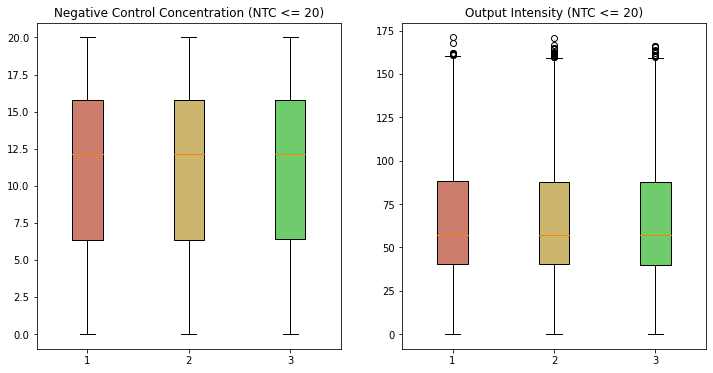

In [50]:
colors = ['#CC7D6C', '#CCB56C', '#6FCC6C']
fig, (ntc_ax, intensity_ax) = plt.subplots(1, 2, figsize = (12,6))

ntc_box = ntc_ax.boxplot(good_NTC, patch_artist=True)
ntc_ax.set_title("Negative Control Concentration (NTC <= 20)")

intBox = intensity_ax.boxplot(good_intensity, patch_artist=True)
intensity_ax.set_title("Output Intensity (NTC <= 20)")

for plot in [ntc_box, intBox]:
    i = 0
    for patch in plot['boxes']:
        patch.set_facecolor(colors[i])
        i += 1


plt.show()

In [51]:
passingSamples = toAnalyze.loc[toAnalyze.Negative_Control_Concentration <= 20, :]

completeSamples = passingSamples.groupby(passingSamples['Sample_ID']).size() == 3
toKeep = completeSamples.index[completeSamples].array

passingSamples = passingSamples[passingSamples['Sample_ID'].isin(toKeep)]

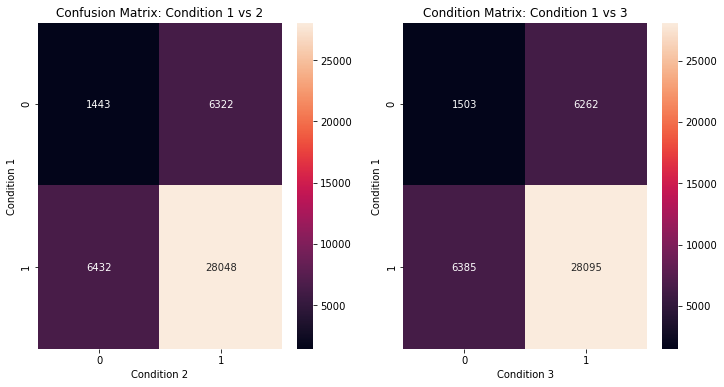

In [70]:
from sklearn.metrics import confusion_matrix

passingSamples.loc[passingSamples['Intensity'] >= 35, "Pass/Fail"] = 1
passingSamples.loc[passingSamples['Intensity'] < 35, "Pass/Fail"] = 0

sortedPassing = passingSamples.sort_values(["Condition", "Sample_ID"])

truthPF = sortedPassing.loc[sortedPassing['Condition'] == 1, "Pass/Fail"]
conditionPF = []

for experiment in [2,3]:
    conditionPF.append(sortedPassing.loc[sortedPassing['Condition'] == experiment, "Pass/Fail"])

fig, (CM1, CM2)  = plt.subplots(1,2, figsize = (12,6))  

sns.heatmap(confusion_matrix(truthPF, conditionPF[0]),annot=True,fmt='3.0f', ax = CM1)
CM1.set_title("Confusion Matrix: Condition 1 vs 2")
CM1.set(xlabel= 'Condition 2', ylabel = 'Condition 1')

sns.heatmap(confusion_matrix(truthPF, conditionPF[1]),annot=True,fmt='3.0f', ax = CM2)
CM2.set_title("Condition Matrix: Condition 1 vs 3")
CM2.set(xlabel= 'Condition 3', ylabel = 'Condition 1')

plt.show()